# Trabalho Final: Detecção e Contagem de Núcleos Celulares
- **Disciplina:** Processamento de Imagens
- **Aluno:** Matheus Henrique Silva de Melo

## 1. Introdução e Objetivo
Este trabalho tem como objetivo desenvolver um sistema automatizado para a detecção e contagem de núcleos celulares de neurônios, utilizando estritamente as técnicas abordadas em sala de aula. A base de dados utilizada foi a *Neurons Nuclei*, disponível no Roboflow.

O foco central deste projeto é resolver o desafio da detecção e contagem dos núcleos de neurônios e, crucialmente, a distinção entre células viáveis e detritos (ruídos) do fundo da imagem.

## 2. Metodologia: Estratégia de "Dupla Detecção Geométrica"
Para superar as limitações da limiarização simples em imagens com contraste variado, adotou-se uma abordagem de **validação cruzada em duas etapas**. Esta estratégia baseia-se na observação da morfologia visual específica destes núcleos, que apresentam dois componentes concêntricos distintos:

1.  **O "Glow" Central (Brilho):** Uma região interna de alta intensidade (quase branca). Embora presente em todos os núcleos, este brilho também aparece de forma isolada em fragmentos celulares, núcleos "escondidos" ou reflexos, que devem ser considerados ruído (falsos positivos) se detectados sozinhos.
2.  **A Borda Cinza (Anel):** Um anel de intensidade média (cinza) que envolve o brilho central, definindo a forma do neurônio e presente conjuntamente com o brilho do reagente quimico fluorescente.

### Algoritmo Proposto
O sistema realiza duas detecções independentes baseadas na **Transformada de Hough Circular (CHT)**, ajustada para capturar frequências espaciais diferentes:
1.  **Detector de Alta Frequência:** Focado em transições abruptas para encontrar os pequenos círculos de brilho ("Glow").
2.  **Detector de Baixa Frequência:** Focado em transições suaves para encontrar os círculos maiores mais escuros do corpo celular ("Borda").

**Critério de Validação:**
Diferente de métodos baseados em cor ou intensidade média, a validação é puramente **geométrica**. Um núcleo só é contabilizado se o algoritmo detectar que um *Glow* está contido dentro de uma *Borda* (cálculo de Distância Euclidiana entre centros por um limiar definido arbitrariamente).

**Técnicas Utilizadas:**
* Conversão para Escala de Cinza (Preservação de Intensidade);
* Detecção de Bordas (Filtro Canny com parâmetros dinâmicos);
* Transformada de Hough Circular (Dupla passagem);
* Geometria Analítica (Distância Euclidiana para validação de inclusão).

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, exposure, img_as_ubyte
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_float
from skimage.transform import hough_circle

# Configuração para melhor visualização no notebook
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['image.cmap'] = 'gray'

## 3. Carregamento da Imagem
Carregamos a imagem e a convertemos para escala de cinza. Não aplicamos binarização. Apenas trabalharemos com a imagem de intensidade original.

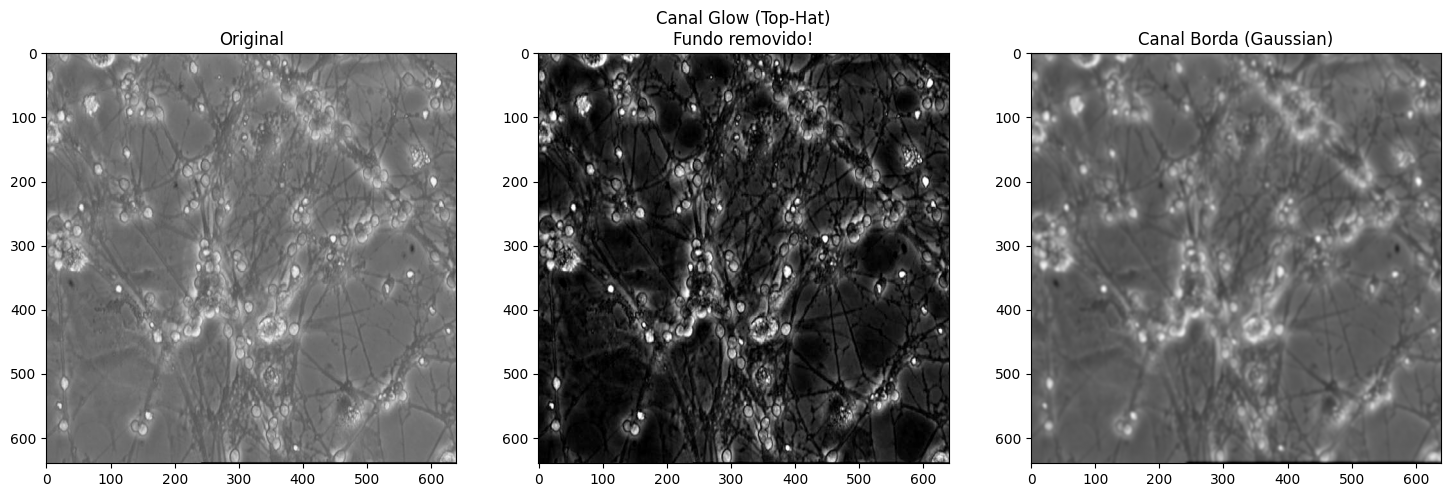

In [133]:
# --- CARREGAMENTO ---
filename = 'Dataset1/neuron0.jpg' # <--- SEU ARQUIVO AQUI
# Nota: O código aceita PDF se for o nome, mas o ideal é carregar a imagem .jpg/.png

try:
    image = io.imread(filename)
    if len(image.shape) > 2:
        image_gray = color.rgb2gray(image)
    else:
        image_gray = image

    # Garantir float para processamento
    image_float = img_as_float(image_gray)
    
    # === CANAL 1: PREPARAÇÃO PARA O GLOW (Top-Hat) ===
    # O Top-Hat remove variações de iluminação do fundo.
    # Usamos um disco de 20px (tamanho aprox do núcleo) para isolar o que é brilho.
    selem = morphology.disk(20)
    image_glow_enhanced = morphology.white_tophat(image_float, selem)
    
    # Aumentamos o contraste do resultado para o Hough pegar fácil
    p2, p98 = np.percentile(image_glow_enhanced, (2, 99.8))
    image_glow_enhanced = exposure.rescale_intensity(image_glow_enhanced, in_range=(p2, p98))

    # === CANAL 2: PREPARAÇÃO PARA A BORDA (Gaussian) ===
    # Suavização para ignorar texturas internas e focar na silhueta
    image_border_enhanced = filters.gaussian(image_float, sigma=2)
    
    # Visualização dos Canais
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_float)
    ax1.set_title("Original")
    ax2.imshow(image_glow_enhanced)
    ax2.set_title("Canal Glow (Top-Hat)\nFundo removido!")
    ax3.imshow(image_border_enhanced)
    ax3.set_title("Canal Borda (Gaussian)")
    plt.show()

except Exception as e:
    print(f"Erro ao carregar imagem: {e}")
    # Cria imagens dummy caso falhe para não quebrar o resto do notebook
    if 'image' not in locals():
        image_float = np.zeros((500,500))
        image_glow_enhanced = np.zeros((500,500))
        image_border_enhanced = np.zeros((500,500))

## 4. Estratégia de Bordas Diferenciadas
Para que o Hough detecte coisas diferentes (Glow vs Borda), precisamos alimentar o algoritmo com **bordas diferentes**.

1.  **Bordas para o Glow (Interno):** Usamos um `sigma` baixo (menos suavização) e limiares altos no detector Canny. Isso isola apenas as transições muito fortes do branco brilhante.
2.  **Bordas para a Borda Cinza (Externo):** Usamos um `sigma` mais alto (mais desfocado) e limiares baixos. Isso ignora o brilho interno e foca na silhueta suave da célula contra o fundo.

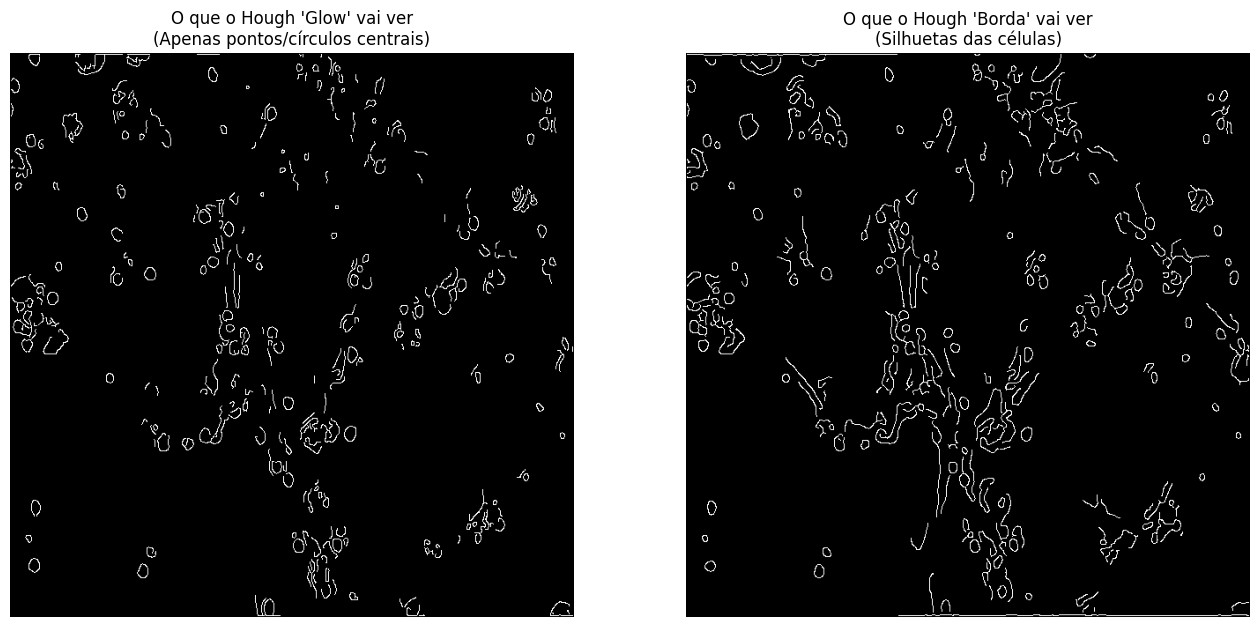

In [134]:
# --- ETAPA DE BORDAS (CANNY) ---

# 1. Canny no Glow (Busca bordas afiadas e brilhantes)
# low_threshold=0.4 garante que ignoramos qualquer resquício cinza do fundo
edges_glow = canny(image_glow_enhanced, sigma=1.0, low_threshold=0.6, high_threshold=1)

# 2. Canny na Borda (Busca silhuetas suaves)
# sigma=3.0 conecta falhas na borda da célula
edges_border = canny(image_border_enhanced, sigma=0.8, low_threshold=0.1, high_threshold=0.2)

# --- VISUALIZAÇÃO CRÍTICA ---
# O Hough só vai funcionar se estas imagens estiverem boas.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(edges_glow, cmap='gray')
ax1.set_title("O que o Hough 'Glow' vai ver\n(Apenas pontos/círculos centrais)")
ax1.axis('off')

ax2.imshow(edges_border, cmap='gray')
ax2.set_title("O que o Hough 'Borda' vai ver\n(Silhuetas das células)")
ax2.axis('off')

plt.show()

## 5. Aplicação da Transformada de Hough (Dupla)
Agora aplicamos a transformada circular nas duas imagens de borda geradas acima, com parâmetros geométricos distintos.

### Função Hough manual
#### Eu utlizei uma função hough circular personalizada (a mesma criada na atividade 4)  que utiliza uma correção de ruído 


* **Hough Glow:** Busca raios similares ao da borda para evitar ruidos que geralmente são muito grandes ou muito pequenos (ex: 2 ou 15 pixels). O limiar de detecção é relaxado para aceitar brilhos mais irregulares.
* **Hough Borda:** Busca raios maiores (ex: 7 a 13 pixels) que são os tamanhos médios dos nucleos aproximadamente. Busca formas mais definidas, nn considerando muito os aglomerados e citoplasmas irregulares como notado na explicação do tema (parte 1 da atividade).

In [135]:
def custom_find_peaks(accumulator, r_range, threshold=0.4, min_dist=20):
    """
    Sua função de filtragem de picos e NMS (Non-Maximum Suppression).
    """
    r_min, r_max = r_range
    
    # Filtra candidatos acima de % do voto máximo global
    # Nota: accumulator deve estar em (Y, X, R)
    max_val = np.max(accumulator)
    if max_val == 0: return np.array([])
    
    y, x, r = np.where(accumulator > max_val * threshold)
    scores = accumulator[y, x, r]
    radii = r + r_min
    
    # Matriz [y, x, raio, score], ordenada pelo score decrescente
    if len(scores) == 0: return np.array([])
    
    detected = np.column_stack((y, x, radii, scores))
    detected = detected[detected[:, 3].argsort()[::-1]]
    
    final_circles = []
    # Loop guloso para eliminar vizinhos próximos (NMS)
    while len(detected) > 0:
        current = detected[0]
        final_circles.append(current)
        
        # Calcula distâncias do atual para o resto e mantém apenas os distantes
        rest = detected[1:]
        if len(rest) == 0: break
        
        # Distância Euclidiana vetorizada
        dists = np.sqrt((rest[:, 0] - current[0])**2 + (rest[:, 1] - current[1])**2)
        
        # Mantém apenas quem está longe o suficiente
        detected = rest[dists > min_dist]
        
    return np.array(final_circles)
    
# --- PARAMETROS UNIFICADOS ---
# Usamos o mesmo range para ambos (6 a 13 pixels)
hough_radii = np.arange(5, 14) 
r_min, r_max = 5, 14
r_range_tuple = (r_min, r_max)

print("--- PROCESSANDO GLOW ---")
# 1. Gera Acumulador Otimizado (Skimage) -> Retorna (Raios, Y, X)
acc_glow_raw = hough_circle(edges_glow, hough_radii)

# 2. Ajusta para sua função: Transforma (R, Y, X) em (Y, X, R)
acc_glow_fixed = np.moveaxis(acc_glow_raw, 0, -1)

# 3. Aplica SUA filtragem
# min_dist=10: Glows muito próximos são fundidos
peaks_glow = custom_find_peaks(acc_glow_fixed, r_range_tuple, threshold=0.4, min_dist=10)


print("--- PROCESSANDO BORDA ---")
# 1. Gera Acumulador
acc_border_raw = hough_circle(edges_border, hough_radii)

# 2. Ajusta eixos
acc_border_fixed = np.moveaxis(acc_border_raw, 0, -1)

# 3. Aplica SUA filtragem
# min_dist=16: Bordas muito próximas são fundidas (evita círculo duplo na mesma célula)
peaks_border = custom_find_peaks(acc_border_fixed, r_range_tuple, threshold=0.45, min_dist=17)

print(f"\nResultados Filtrados (NMS):")
print(f"Glows: {len(peaks_glow)}")
print(f"Bordas: {len(peaks_border)}")

--- PROCESSANDO GLOW ---
--- PROCESSANDO BORDA ---

Resultados Filtrados (NMS):
Glows: 174
Bordas: 126


## 6. Cruzamento Geométrico (Sem Limiarização)
Nesta etapa final, não analisamos a cor dos pixels. Analisamos apenas a geometria dos círculos detectados.

**Algoritmo de Validação:**
1.  Pegamos um Círculo de Borda (Grande).
2.  Verificamos se existe algum Círculo de Glow (Pequeno) cujo centro esteja geometricamente **dentro** do Círculo de Borda.
3.  Se sim -> É um neurônio.
4.  Se não -> É descarte.

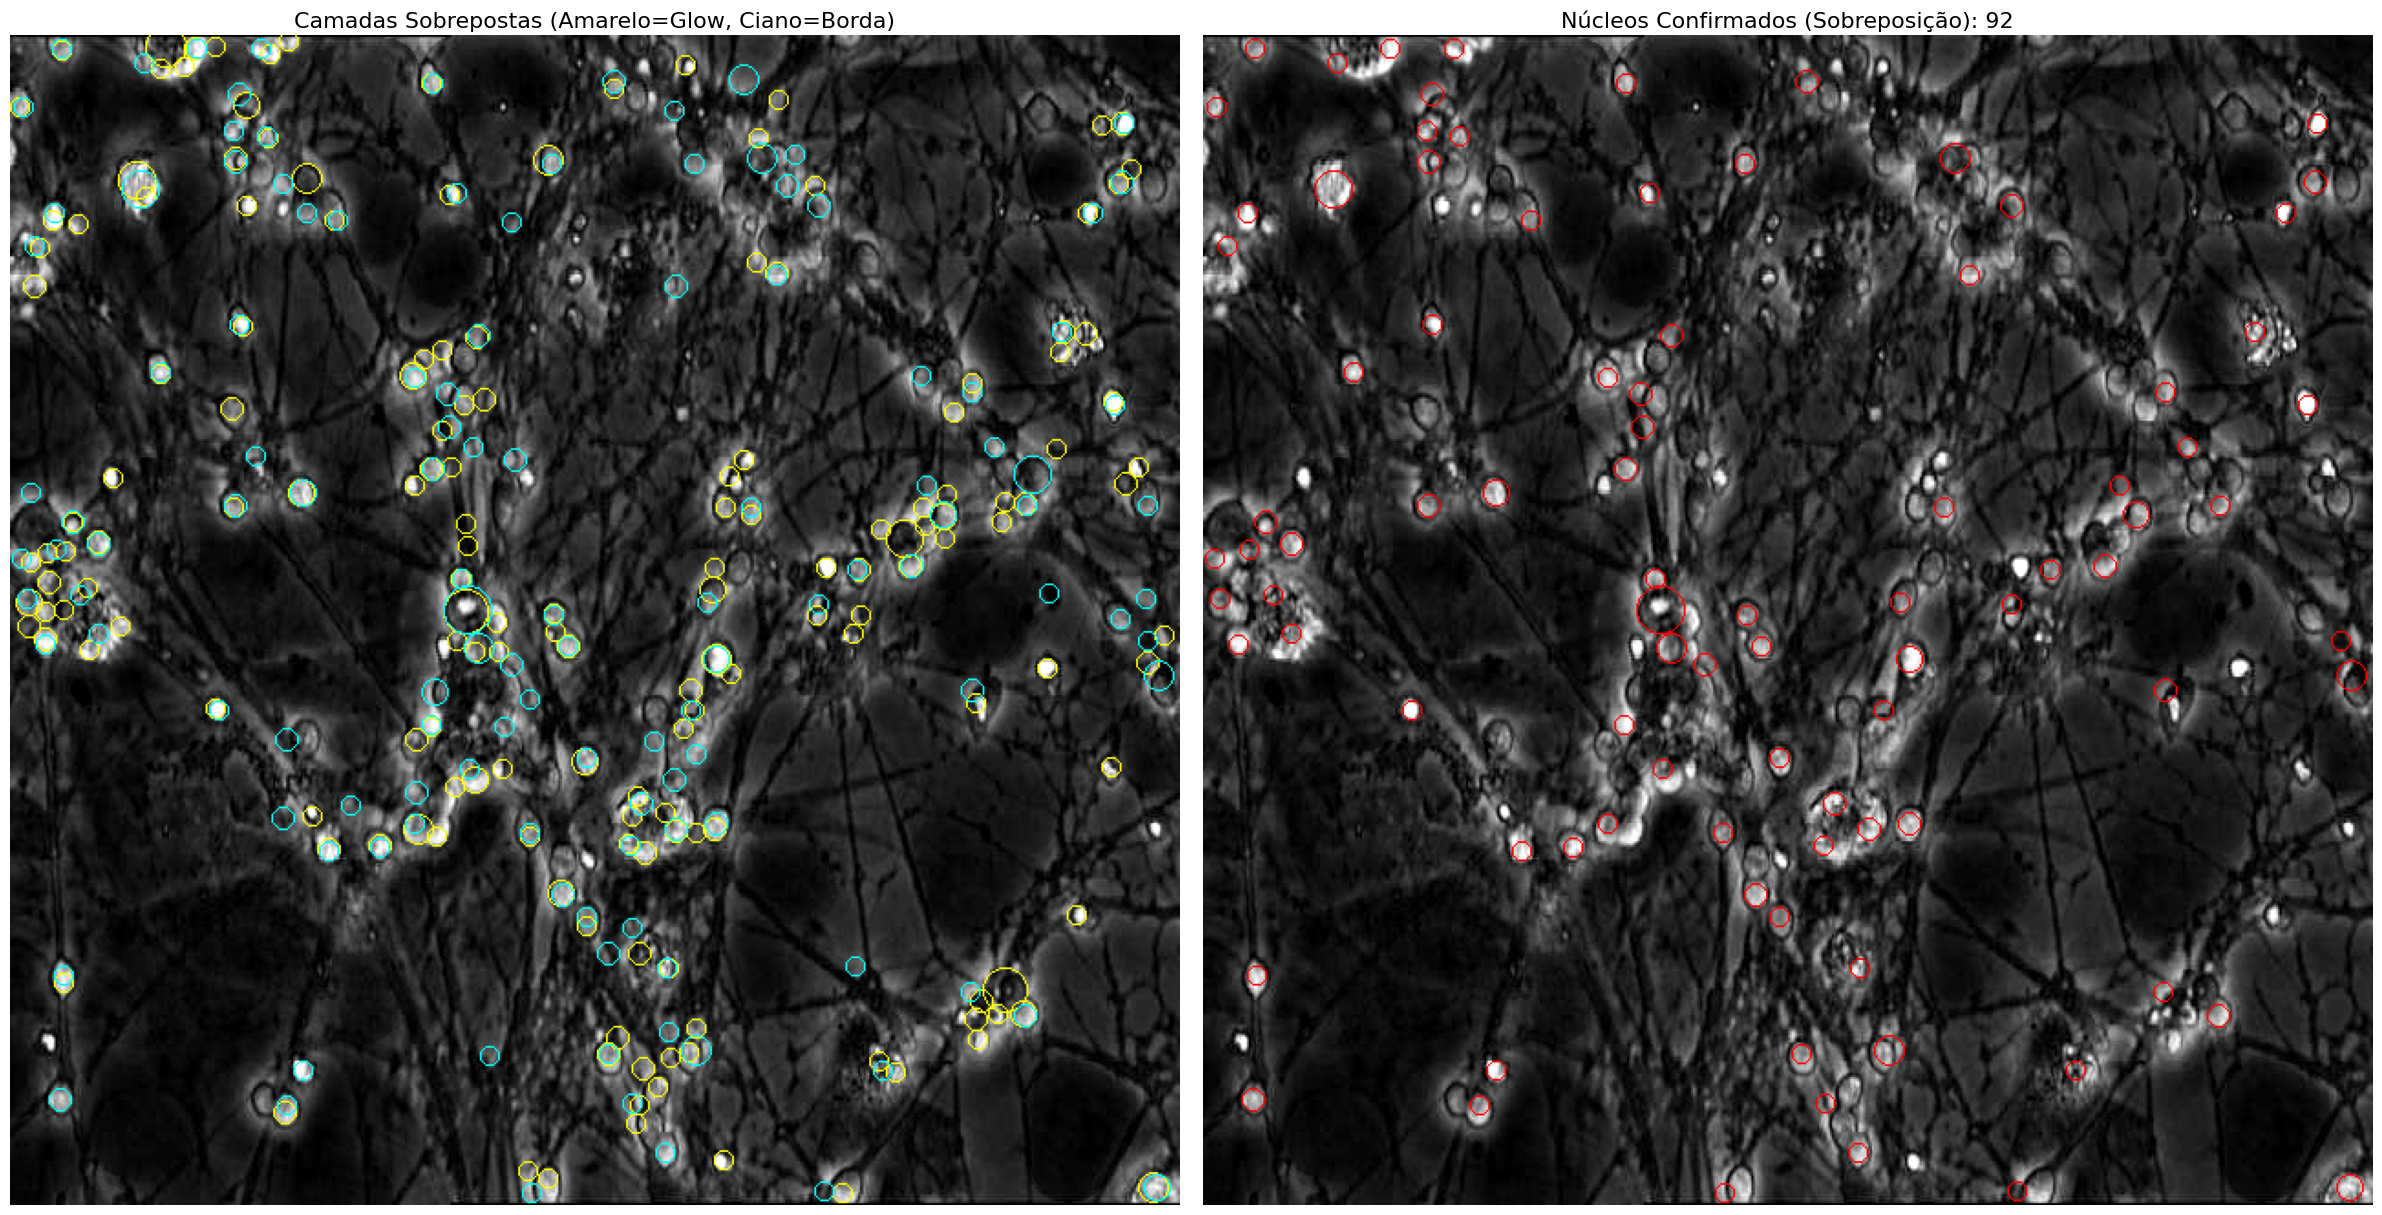

In [136]:
confirmed_nuclei = []

# --- VALIDAÇÃO POR COINCIDÊNCIA ---
# Só aceita se tiver Glow E Borda no mesmo lugar
if len(peaks_border) > 0 and len(peaks_glow) > 0:
    for circle_b in peaks_border:
        y_b, x_b, r_b, score_b = circle_b
        
        has_match = False
        for circle_g in peaks_glow:
            y_g, x_g, r_g, score_g = circle_g
            
            # Distância Euclidiana
            dist = np.sqrt((y_b - y_g)**2 + (x_b - x_g)**2)
            
            # Se a distância for pequena (ex: < 8px), confirmamos o núcleo
            if dist < 13.0:
                has_match = True
                break
        
        if has_match:
            confirmed_nuclei.append((y_b, x_b, r_b))

# --- PLOTAGEM ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
img_rgb = color.gray2rgb(image_glow_enhanced)

# ESQUERDA: DEBUG
img_diag = img_rgb.copy()
# Glows (Amarelo)
for c in peaks_glow:
    cy, cx = circle_perimeter(int(c[0]), int(c[1]), int(c[2]), shape=img_diag.shape[:2])
    img_diag[cy, cx] = (1, 1, 0)
# Bordas (Ciano)
for c in peaks_border:
    cy, cx = circle_perimeter(int(c[0]), int(c[1]), int(c[2]), shape=img_diag.shape[:2])
    img_diag[cy, cx] = (0, 1, 1)

ax1.imshow(img_diag)
ax1.set_title(f"Camadas Sobrepostas (Amarelo=Glow, Ciano=Borda)", fontsize=16)
ax1.axis('off')

# DIREITA: FINAL
img_final = img_rgb.copy()
for y, x, r in confirmed_nuclei:
    cy, cx = circle_perimeter(int(y), int(x), int(r), shape=img_final.shape[:2])
    img_final[cy, cx] = (1, 0, 0) # Vermelho

ax2.imshow(img_final)
ax2.set_title(f"Núcleos Confirmados (Sobreposição): {len(confirmed_nuclei)}", fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()